In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as seaborn
import sklearn.metrics as skm

import statsmodels.api as smapi
from lr_model.LinearRegressionImpl import LinearRegressionImpl

%matplotlib inline
light_blue_color = color_for_origin = '#23A1D7'
orange_color = color_for_train = 'orange'
pink_red_color = color_for_test = '#E52659'

## Определение количества просмотров нормативного акта ##

***боже, кто бы знал, что этот сет будет еще где-то использоваться );***

In [2]:
df = pd.read_csv('data/gov30.csv', sep=';')
df.head()

,projectId,department,documentType,title,progress,views,project_card_sizeKb
0,142304,Минкультуры России,Проект постановления Правительства Российской ...,Об утверждении Правил предоставления субсидии ...,0.000000,113,0.611328
1,142303,Минфин России,Проект постановления Правительства Российской ...,О внесении изменений в некоторые акты Правител...,0.000000,190,0.279297
2,142290,ФАС России,Проект ведомственного акта,Об утверждении предельных максимальных аэропор...,0.000000,53,0.537109
3,142287,ФАС России,Проект ведомственного акта,Об утверждении предельных максимальных аэропор...,0.000000,54,0.537109
4,142308,Минздрав России,Проект ведомственного акта,Об утверждении Перечня индикаторов риска наруш...,0.285714,269,0.581055


In [3]:
df.shape

(809, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   projectId            809 non-null    int64  
 1   department           809 non-null    object 
 2   documentType         809 non-null    object 
 3   title                809 non-null    object 
 4   progress             809 non-null    float64
 5   views                809 non-null    int64  
 6   project_card_sizeKb  809 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 44.4+ KB


In [5]:
df.describe()

,projectId,progress,views,project_card_sizeKb
count,809.000000,809.000000,809.000000,809.000000
mean,141852.746601,0.780478,323.698393,0.485484
std,284.020139,0.310799,1102.785132,0.114025
min,138890.000000,0.000000,37.000000,0.214844
25%,141642.000000,0.571429,148.000000,0.377930
50%,141856.000000,1.000000,219.000000,0.510742
75%,142072.000000,1.000000,324.000000,0.580078
max,142308.000000,1.000000,29441.000000,0.693359


**Columns 'projectId' and 'title' won't be used since their values are unique and therefore not significant in defining views amount for project**
*But wouldn't be amiss to assume that the length of the title has an impact on the number of views, so that feature will be mapped to length
'project_card_sizeKb' is also not really informative metric that can has an effect on views because this value can depends, for example, on picture size thus it also won't be used*

Drop unused 'projectId', 'project_card_sizeKb'

In [6]:
df = df.drop(['projectId', 'project_card_sizeKb'], axis=1)

Map 'title' string value into integer value of its length

In [7]:
df['titleLen'] = df['title'].map(lambda x: x.__len__())
df = df.drop('title', axis=1)
df.head()

,department,documentType,progress,views,titleLen
0,Минкультуры России,Проект постановления Правительства Российской ...,0.000000,113,469
1,Минфин России,Проект постановления Правительства Российской ...,0.000000,190,72
2,ФАС России,Проект ведомственного акта,0.000000,53,376
3,ФАС России,Проект ведомственного акта,0.000000,54,408
4,Минздрав России,Проект ведомственного акта,0.285714,269,344


In [8]:
df['documentType'].unique()

array(['Проект постановления Правительства Российской Федерации',
       'Проект ведомственного акта', 'Проект федерального закона',
       'Проект указа Президента Российской Федерации',
       'Проект решения Евразийской экономической комиссии',
       'Распоряжение правительства РФ',
       'Публикация проекта перечня нормативных правовых актов, содержащих обязательные требования, подлежащие оценке применения'],
      dtype=object)

'documentType' is a categorical feature, has 7 distinct values, and it is imposible to use it in immutable state for linear regression model
So we map this feature by dummy encoding to 7 different mutually exclusive features

In [9]:
df[['departActProject', 'goverResolution', 'eurasianSolvProject',
    'presidentProject', 'federalLawProject', 'listNormativeActs',
    'goverOrder']] = pd.get_dummies(df['documentType'], dtype=float)

In [10]:
df.head()

,department,documentType,progress,views,titleLen,departActProject,goverResolution,eurasianSolvProject,presidentProject,federalLawProject,listNormativeActs,goverOrder
0,Минкультуры России,Проект постановления Правительства Российской ...,0.000000,113,469,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Минфин России,Проект постановления Правительства Российской ...,0.000000,190,72,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ФАС России,Проект ведомственного акта,0.000000,53,376,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ФАС России,Проект ведомственного акта,0.000000,54,408,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Минздрав России,Проект ведомственного акта,0.285714,269,344,1.0,0.0,0.0,0.0,0.0,0.0,0.0


*'department' is also categorical feature with 65 distinct values and for this case there are to many kinds of one feature, so let's map them to more generalized categories*

In [11]:
for dep in df['department'].unique():
    print(dep)
general_categories = {
    'Минкультуры России': 'civil', 'Минфин России': 'economy', 'ФАС России': 'economy',
    'Минздрав России': 'civil', 'Минюст России': 'juridic', 'ФТС России': 'siloviki',
    'Минобороны России': 'siloviki', 'МЧС России': 'nature', 'Россотрудничество': 'international',
    'Росреестр': 'juridic', 'Росаккредитация': 'juridic', 'СФР': 'civil', 'Росавиация': 'civil',
    'Росводресурсы': 'nature', 'МВД России': 'siloviki', 'Минсельхоз России': 'civil',
    'Минэкономразвития России': 'economy',
    'Минтранс России': 'civil', 'Минпромторг России': 'economy', 'Минобрнауки России': 'civil',
    'Минприроды России': 'nature', 'ФСИН России': 'siloviki', 'Центральный банк Российской Федерации': 'economy',
    'Росавтодор': 'civil', 'Роскомнадзор': 'juridic', 'Минтруд России': 'civil',
    'Минспорт России': 'civil', 'Росалкогольрегулирование': 'juridic', 'Минцифры России': 'juridic',
    'МИД России': 'international', 'Минпросвещения России': 'civil', 'Минстрой России': 'civil',
    'Ростехнадзор': 'juridic', 'Минэнерго России': 'civil', 'ФНС России': 'economy',
    'Госкорпорация "Росатом"': 'economy', 'Росгвардия': 'siloviki',
    'Следственный комитет Российской Федерации': 'siloviki',
    'Росздравнадзор': 'juridic', 'ФМБА России': 'juridic', 'Минкомсвязь России': 'civil',
    'Ространснадзор': 'juridic', 'ГФС России': 'siloviki',
    'Генеральная прокуратура Российской Федерации': 'siloviki', 'Минвостокразвития России': 'economy',
    'ФСБ России': 'siloviki', 'ФСО России': 'siloviki', 'Росстат': 'civil',
    'Рособрнадзор': 'juridic', 'ГУСП': 'siloviki', 'Роспотребнадзор': 'juridic',
    'Рослесхоз': 'nature', 'Казначейство России': 'economy', 'ФССП России': 'siloviki',
    'Россельхознадзор': 'juridic', 'Росрыболовство': 'nature', 'Госкорпорация "Роскосмос"': 'economy',
    'Судебный департамент': 'juridic', 'Росгидромет': 'nature', 'ФФОМС': 'civil',
    'Роспатент': 'economy', 'Росприроднадзор': 'nature',
    'Управление делами Президента Российской Федерации': 'juridic',
    # todo: 'unnecessaryBullshit' cat. merge with some of 'siloviki'
    'Росфинмониторинг': 'economy', 'Росимущество': 'juridic'
}


def generalize_departments(department):
    return general_categories.get(department)


print('--------------------')
gen_departments = set(map(generalize_departments, df['department'].unique()))
for gd in gen_departments:
    print(gd)


Минкультуры России
Минфин России
ФАС России
Минздрав России
Минюст России
ФТС России
Минобороны России
МЧС России
Россотрудничество
Росреестр
Росаккредитация
СФР
Росавиация
Росводресурсы
МВД России
Минсельхоз России
Минэкономразвития России
Минтранс России
Минпромторг России
Минобрнауки России
Минприроды России
ФСИН России
Центральный банк Российской Федерации
Росавтодор
Роскомнадзор
Минтруд России
Минспорт России
Росалкогольрегулирование
Минцифры России
МИД России
Минпросвещения России
Минстрой России
Ростехнадзор
Минэнерго России
ФНС России
Госкорпорация "Росатом"
Росгвардия
Следственный комитет Российской Федерации
Росздравнадзор
ФМБА России
Минкомсвязь России
Ространснадзор
ГФС России
Генеральная прокуратура Российской Федерации
Минвостокразвития России
ФСБ России
ФСО России
Росстат
Рособрнадзор
ГУСП
Роспотребнадзор
Рослесхоз
Казначейство России
ФССП России
Россельхознадзор
Росрыболовство
Госкорпорация "Роскосмос"
Судебный департамент
Росгидромет
ФФОМС
Роспатент
Росприроднадзор
Упр

Got 6 generalized categories from 65 original

In [12]:
df['departmentGen'] = df['department'].map(generalize_departments)
pd.get_dummies(df['departmentGen'], dtype=float)

,civil,economy,international,juridic,nature,siloviki
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
804,1.0,0.0,0.0,0.0,0.0,0.0
805,1.0,0.0,0.0,0.0,0.0,0.0
806,0.0,0.0,0.0,0.0,1.0,0.0
807,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
df[['depCivil', 'depEconomy', 'depInternational', 'depJuridic', 'depNature', 'depSiloviki']] = pd.get_dummies(
    df['departmentGen'], dtype=float)
df.head()


,department,documentType,progress,views,titleLen,departActProject,goverResolution,eurasianSolvProject,presidentProject,federalLawProject,listNormativeActs,goverOrder,departmentGen,depCivil,depEconomy,depInternational,depJuridic,depNature,depSiloviki
0,Минкультуры России,Проект постановления Правительства Российской ...,0.000000,113,469,0.0,1.0,0.0,0.0,0.0,0.0,0.0,civil,1.0,0.0,0.0,0.0,0.0,0.0
1,Минфин России,Проект постановления Правительства Российской ...,0.000000,190,72,0.0,1.0,0.0,0.0,0.0,0.0,0.0,economy,0.0,1.0,0.0,0.0,0.0,0.0
2,ФАС России,Проект ведомственного акта,0.000000,53,376,1.0,0.0,0.0,0.0,0.0,0.0,0.0,economy,0.0,1.0,0.0,0.0,0.0,0.0
3,ФАС России,Проект ведомственного акта,0.000000,54,408,1.0,0.0,0.0,0.0,0.0,0.0,0.0,economy,0.0,1.0,0.0,0.0,0.0,0.0
4,Минздрав России,Проект ведомственного акта,0.285714,269,344,1.0,0.0,0.0,0.0,0.0,0.0,0.0,civil,1.0,0.0,0.0,0.0,0.0,0.0


// вопрос проверяющему: сейчас уравнение регрессии будет зависеть от 15 переменных, мне сложно оценить, насколько такое количество для данного случая велико, и тогда стоит сделать категориальные признаки еще более обобщенными, например, помапив 'documentType' to 3 значения, и 'department' примерно в такое же кол-во, или это вполне нормальное число признаков?

Create to additional collumns 'departmentNum', 'docTypeNum' for dependencies graphs

In [14]:
depToNum = {}
for name, num in zip(df['departmentGen'].unique(), range(1, df['departmentGen'].unique().__len__() + 1)):
    depToNum[name] = num
print(depToNum)

df['departmentNum'] = df['departmentGen'].map(lambda x: depToNum.get(x))

dTypeToNum = {}
for name, num in zip(df['documentType'].unique(), range(1, df['documentType'].unique().__len__() + 1)):
    dTypeToNum[name] = num

df['docTypeNum'] = df['documentType'].map(lambda x: dTypeToNum.get(x))
df.head()


{'civil': 1, 'economy': 2, 'juridic': 3, 'siloviki': 4, 'nature': 5, 'international': 6}


,department,documentType,progress,views,titleLen,departActProject,goverResolution,eurasianSolvProject,presidentProject,federalLawProject,...,goverOrder,departmentGen,depCivil,depEconomy,depInternational,depJuridic,depNature,depSiloviki,departmentNum,docTypeNum
0,Минкультуры России,Проект постановления Правительства Российской ...,0.000000,113,469,0.0,1.0,0.0,0.0,0.0,...,0.0,civil,1.0,0.0,0.0,0.0,0.0,0.0,1,1
1,Минфин России,Проект постановления Правительства Российской ...,0.000000,190,72,0.0,1.0,0.0,0.0,0.0,...,0.0,economy,0.0,1.0,0.0,0.0,0.0,0.0,2,1
2,ФАС России,Проект ведомственного акта,0.000000,53,376,1.0,0.0,0.0,0.0,0.0,...,0.0,economy,0.0,1.0,0.0,0.0,0.0,0.0,2,2
3,ФАС России,Проект ведомственного акта,0.000000,54,408,1.0,0.0,0.0,0.0,0.0,...,0.0,economy,0.0,1.0,0.0,0.0,0.0,0.0,2,2
4,Минздрав России,Проект ведомственного акта,0.285714,269,344,1.0,0.0,0.0,0.0,0.0,...,0.0,civil,1.0,0.0,0.0,0.0,0.0,0.0,1,2


<Axes: >

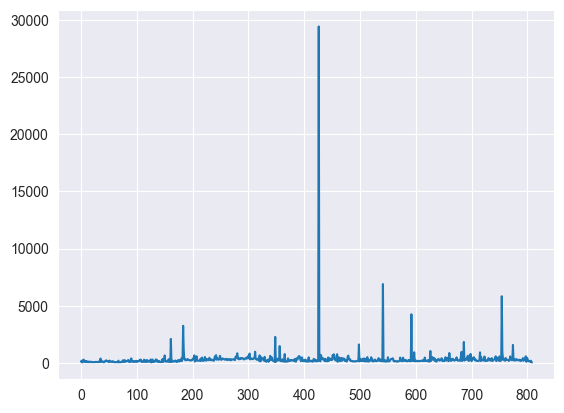

In [15]:
df['views'].plot()

Logarithm values of 'views'

<Axes: >

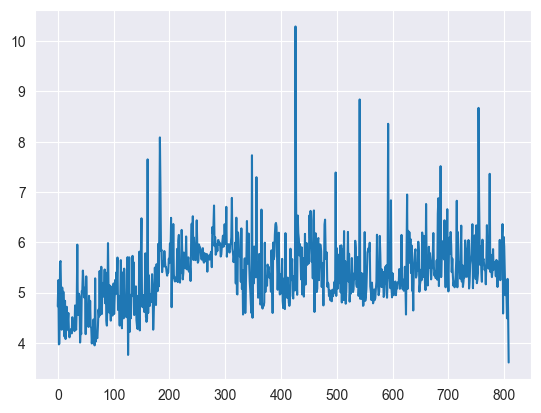

In [16]:
df_exdog = df[['progress', 'titleLen', 'departActProject', 'goverResolution',
               'eurasianSolvProject', 'presidentProject', 'federalLawProject', 'listNormativeActs',
               'goverOrder', 'depCivil', 'depEconomy', 'depJuridic', 'depNature',
               'depSiloviki']]

df['viewsLog'] = np.log(df['views'])
df_for_dependence = df[['progress', 'titleLen', 'departmentNum', 'docTypeNum', 'viewsLog']]
df['viewsLog'].plot()

#### Assessment of dependencies between features

**Correlation matrix**

(5.5, -0.5)

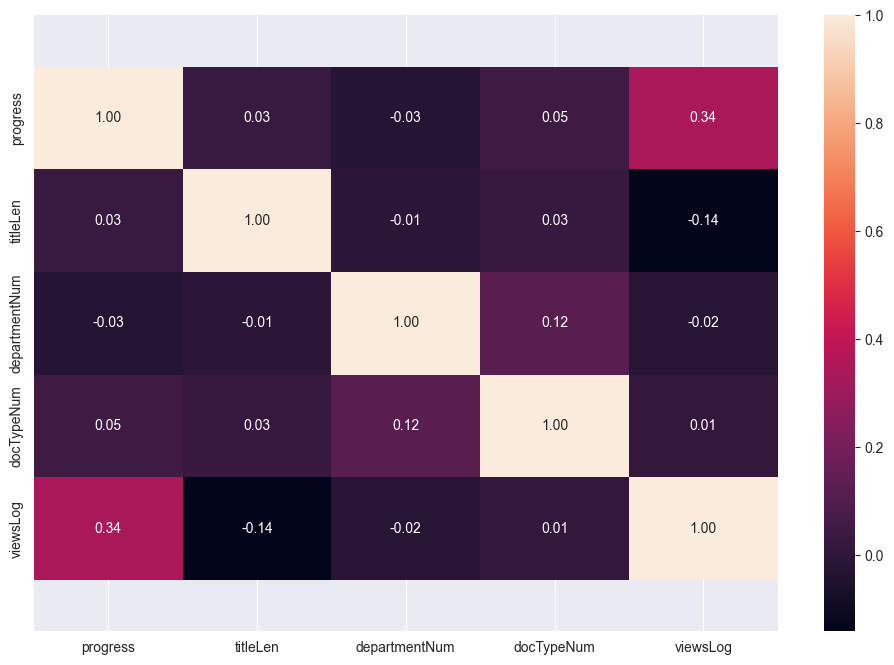

In [17]:
import seaborn as sns

plt.figure(figsize=(12, 8))
ax = sns.heatmap(df_for_dependence.corr(), annot=True, fmt=".2f")
i, k = ax.get_ylim()
ax.set_ylim(i + 0.5, k - 0.5)

As it can be seen, all features have low correlation with each other

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


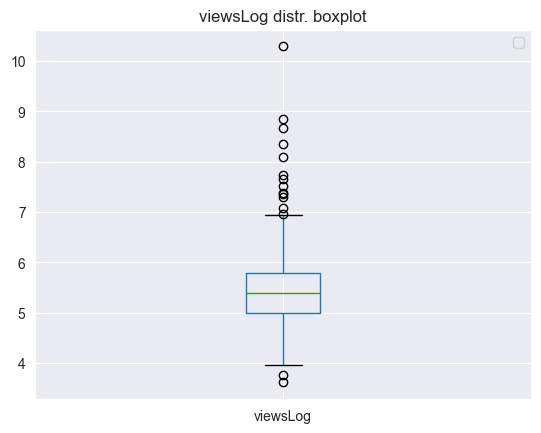

In [18]:
df.boxplot(column='viewsLog')
plt.title('viewsLog distr. boxplot')
plt.legend()
plt.show()

<Axes: title={'center': 'Histogram. The distribution is most similar to Weibull'}>

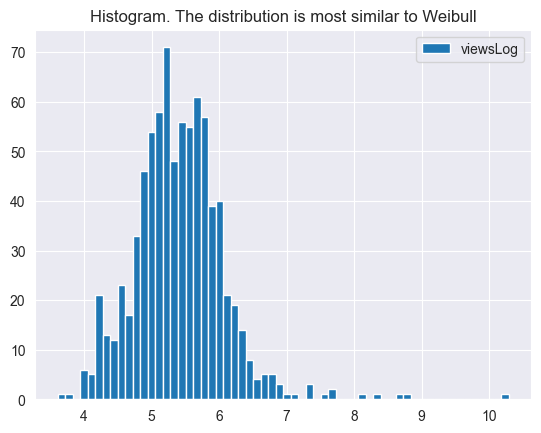

In [19]:
plt.title('Histogram. The distribution is most similar to Weibull')
df["viewsLog"].hist(bins=60, legend=True)

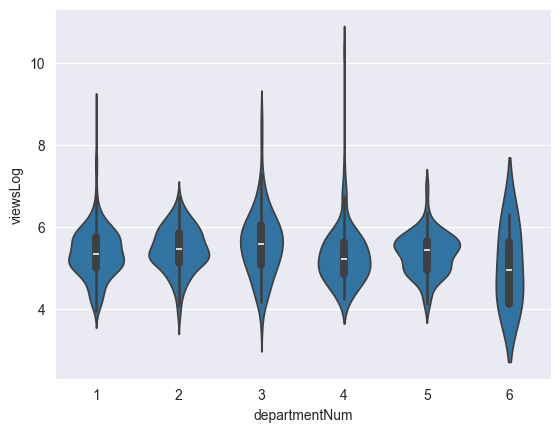

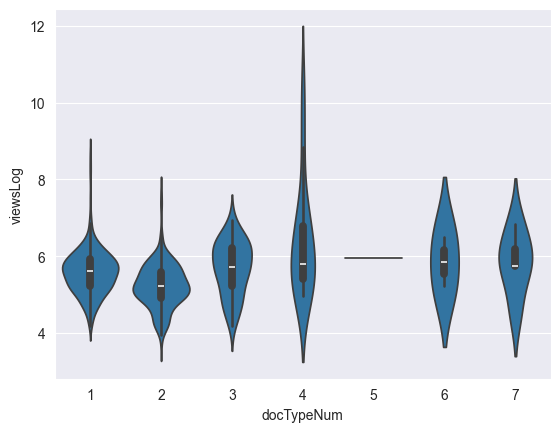

In [20]:
features_for_violin = ['departmentNum', 'docTypeNum']

for feature in features_for_violin:
    sns.violinplot(x=df[feature], y=df['viewsLog'])
    plt.show()

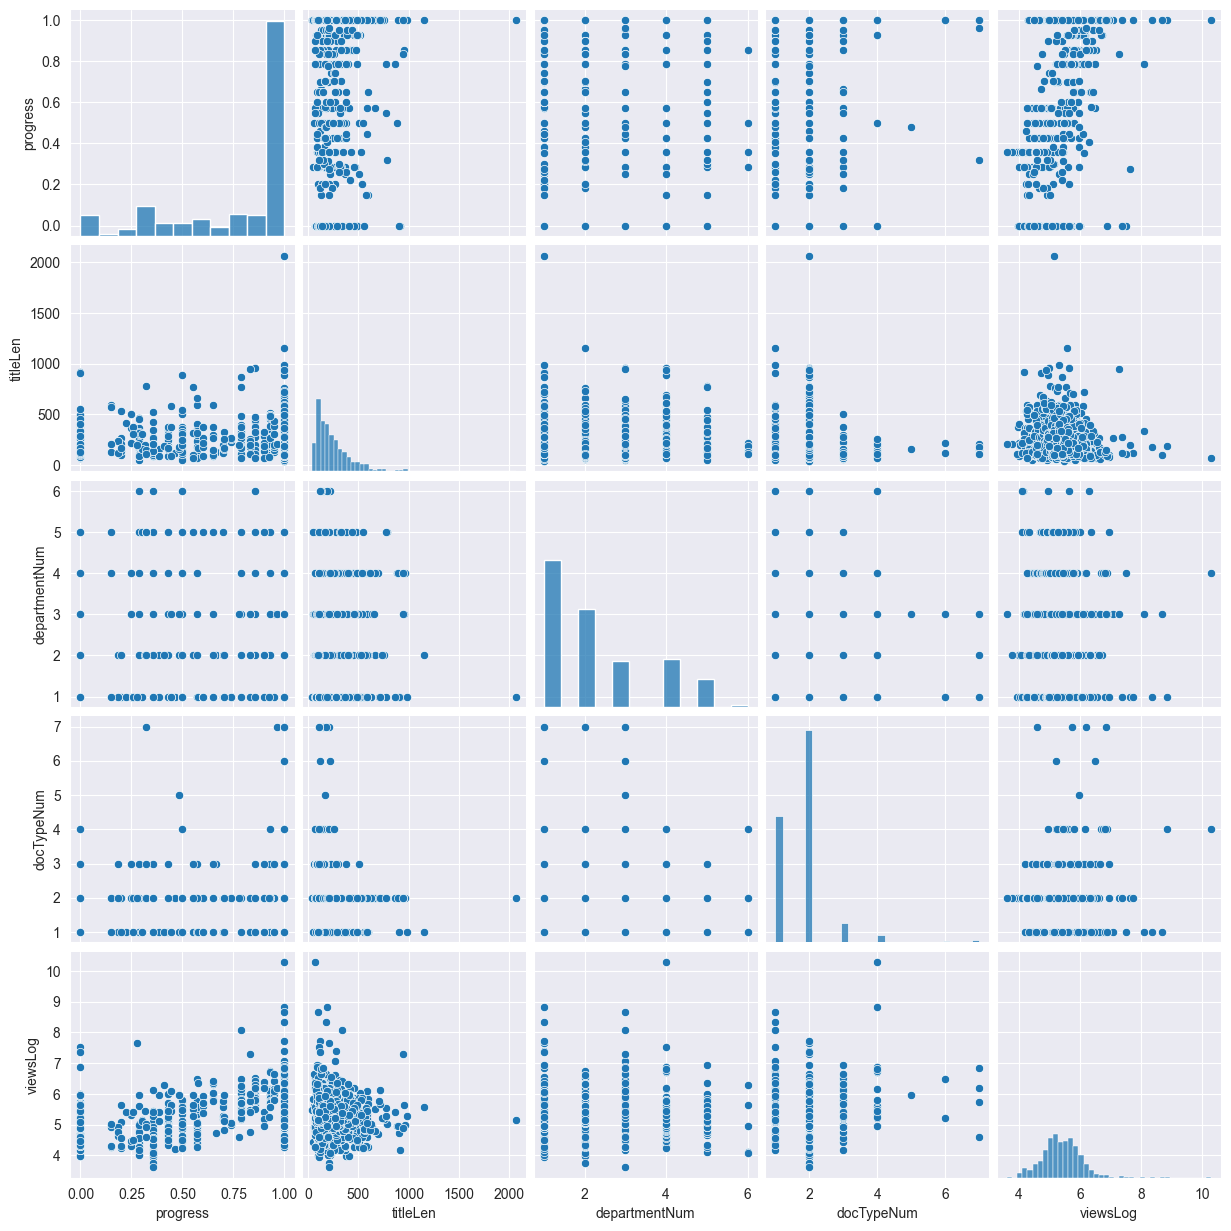

In [21]:
sns.pairplot(df_for_dependence.iloc[:, :])

Conclusion: there are no significant dependencies between features

***Split data to train and test***

In [22]:
from sklearn.model_selection import train_test_split

train_exdog, test_exdog, train_res, test_res = train_test_split(df_exdog, df['viewsLog'], test_size=0.2,
                                                                random_state=42)
train_len = train_res.__len__()
test_len = test_res.__len__()
length = df['viewsLog'].__len__()

In [23]:
lib_model = smapi.OLS(endog=train_res, exog=train_exdog, missing='drop')
type(lib_model)

statsmodels.regression.linear_model.OLS

In [24]:
lib_results = lib_model.fit()
type(lib_results)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [25]:
print(lib_results.summary())

                            OLS Regression Results                            
Dep. Variable:               viewsLog   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     14.42
Date:                Thu, 09 Nov 2023   Prob (F-statistic):           1.46e-28
Time:                        00:05:14   Log-Likelihood:                -542.13
No. Observations:                 647   AIC:                             1112.
Df Residuals:                     633   BIC:                             1175.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
progress                0.6585    

In [26]:
print(lib_results.params)
predicted_lib = lib_model.predict(params=lib_results.params,
                                  exog=test_exdog)



progress               0.658526
titleLen              -0.000278
departActProject       4.426451
goverResolution        4.791902
eurasianSolvProject    5.107832
presidentProject       5.013607
federalLawProject      4.801113
listNormativeActs      4.656795
goverOrder             4.764483
depCivil               0.361456
depEconomy             0.352362
depJuridic             0.583922
depNature              0.364392
depSiloviki            0.342371
dtype: float64


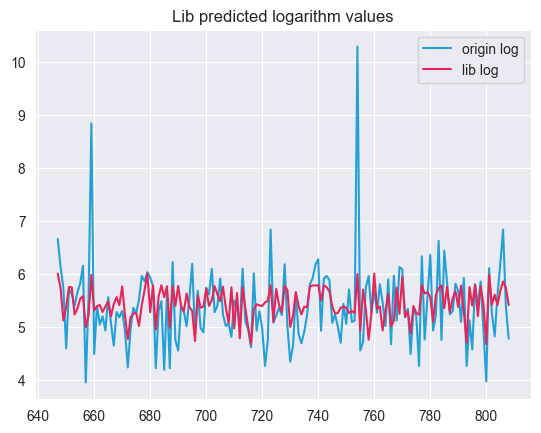

In [27]:
plt.plot(range(train_len, length, 1), test_res, c=color_for_origin, label='origin log')
plt.plot(range(train_len, length, 1), predicted_lib, c=color_for_test, label='lib log')
plt.title('Lib predicted logarithm values')
plt.legend()
plt.show()

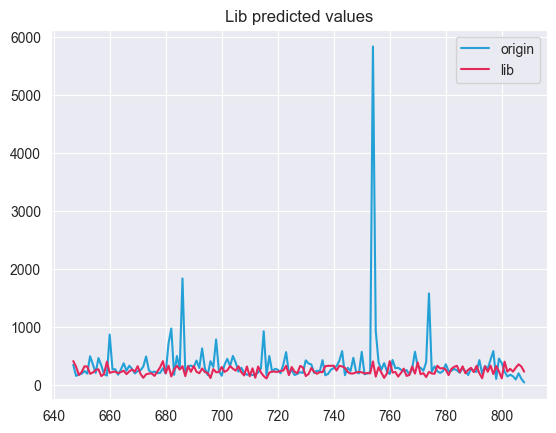

In [28]:
plt.plot(range(train_len, length, 1), df['views'][train_len:length], c=color_for_origin, label='origin')
plt.plot(range(train_len, length, 1), np.exp(predicted_lib), c=color_for_test, label='lib')
plt.title('Lib predicted values')
plt.legend()
plt.show()

**Apply implemented model**

In [37]:
model_impl = LinearRegressionImpl(exdog=df_exdog, endog=df['viewsLog'], test_part=0.2, shuffle=True)
model_impl.fit()
print(model_impl.get_coefs_as_map().__str__())
model_impl.predict()
predicted_impl = model_impl.test_endog

{'progress': 0.6585258304129259, 'titleLen': -0.000277560032759335, 'departActProject': -0.36814636066963474, 'goverResolution': -0.0026959057975621896, 'eurasianSolvProject': 0.3132340575439316, 'presidentProject': 0.2190089616975728, 'federalLawProject': 0.00651582245591513, 'listNormativeActs': -0.13780227099525988, 'goverOrder': -0.030114304234963574, 'depCivil': 0.3614556456258171, 'depEconomy': 0.35236233690463536, 'depJuridic': 0.5839223549958635, 'depNature': 0.3643924947879627, 'depSiloviki': 0.34237066210327555}


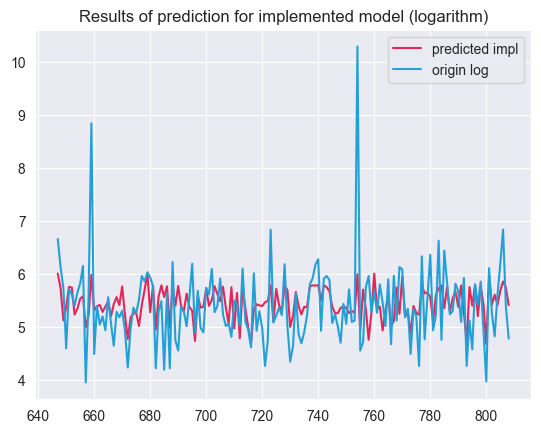

In [38]:
plt.plot(range(model_impl.train_len, model_impl.data_len), predicted_impl, c=color_for_test, label='predicted impl')
plt.plot(range(model_impl.train_len, model_impl.data_len), model_impl.test_ans, c=color_for_origin, label='origin log')
plt.title('Results of prediction for implemented model (logarithm)')
plt.legend()
plt.show()

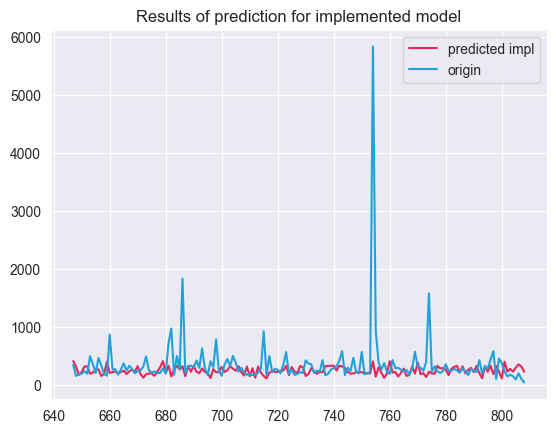

In [39]:
plt.plot(range(model_impl.train_len, model_impl.data_len), np.exp(predicted_impl), c=color_for_test,
         label='predicted impl')
plt.plot(range(model_impl.train_len, model_impl.data_len), df['views'][model_impl.train_len:], c=color_for_origin,
         label='origin')
plt.title('Results of prediction for implemented model')
plt.legend()
plt.show()

**Compare lib and implemented models**

In [40]:
from prettytable import PrettyTable


def smape(real, preds):
    return 100 / len(real) * np.sum(2 * np.abs(real - preds) / (np.abs(real) + np.abs(preds)))


table = PrettyTable()
table.field_names = ['Metric', 'LRLib', 'LRImpl', 'diff*10^14', 'Lib<->Impl *10^14']
metrics = [(skm.mean_absolute_error, 'MAE'), (skm.mean_absolute_percentage_error, 'MAPE'), (smape, 'SMAPE'),
           (skm.mean_squared_log_error, 'MSLE'),
           (skm.mean_gamma_deviance, 'MGDev')]
origin_test_section = df['views'][train_len:]
predicted_lib_exp = np.exp(predicted_lib)
predicted_impl_exp = np.exp(predicted_impl)

for metric, name in metrics:
    lib = metric(origin_test_section, predicted_lib_exp)
    impl = metric(origin_test_section, predicted_impl_exp)
    metric_between = metric(predicted_lib_exp, predicted_impl_exp)
    table.add_row([name, '{lib:.4f}'.format(lib=lib), '{impl:.4f}'.format(impl=impl),
                   '{diff:.4f}'.format(diff=(lib - impl) * 10 ** 14), '{mb:.4f}'.format(mb=metric_between * 10 ** 14)])

In [41]:
print(table)

+--------+----------+----------+------------+-------------------+
| Metric |  LRLib   |  LRImpl  | diff*10^14 | Lib<->Impl *10^14 |
+--------+----------+----------+------------+-------------------+
|  MAE   | 174.0060 | 174.0060 |  31.2639   |      81.4580      |
|  MAPE  |  0.4354  |  0.4354  |   0.0888   |       0.3715      |
| SMAPE  | 44.0559  | 44.0559  |  16.3425   |      37.1546      |
|  MSLE  |  0.4351  |  0.4351  |   0.2276   |       0.0000      |
| MGDev  |  0.6986  |  0.6986  |   0.3331   |      -0.0022      |
+--------+----------+----------+------------+-------------------+


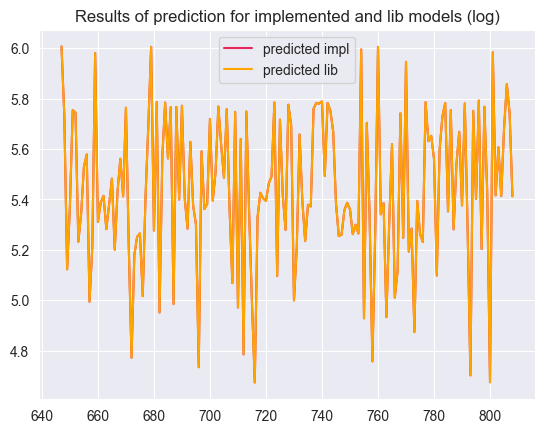

In [42]:
plt.plot(range(model_impl.train_len, model_impl.data_len), predicted_impl, c=color_for_test, label='predicted impl')
plt.plot(range(model_impl.train_len, model_impl.data_len), predicted_lib, c=color_for_train, label='predicted lib')
plt.title('Results of prediction for implemented and lib models (log)')
plt.legend()
plt.show()

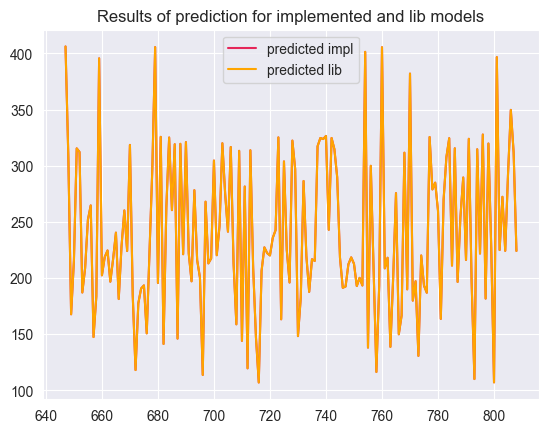

In [43]:
plt.plot(range(model_impl.train_len, model_impl.data_len), predicted_impl_exp, c=color_for_test, label='predicted impl')
plt.plot(range(model_impl.train_len, model_impl.data_len), predicted_lib_exp, c=color_for_train, label='predicted lib')
plt.title('Results of prediction for implemented and lib models')
plt.legend()
plt.show()